# Beam-beam and DA

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import numpy as np
import matplotlib.pyplot as plt
xo.context_cpu._suppress_warnings = True

#### Load LHC Model

In [3]:
collider = xt.Multiline.from_json('collider_00_from_mad.json')

Loading line from dict:   0%|          | 0/23684 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23684 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           

This file will become unreadable in the future. We recommend to save it as an Environment object. This can be easily done as follows:

    import xtrack as xt
    env = xt.Multiline.from_json("my_old_multiline.json")
    env.to_json("my_new_environment.json")



#### Switch on RF

In [4]:
collider.vars['vrf400'] = 16

#### Install beam-beam lenses in both rings

In [5]:
collider.install_beambeam_interactions(
    clockwise_line='lhcb1', anticlockwise_line='lhcb2',
    harmonic_number=35640, bunch_spacing_buckets=10, 
    ip_names=['ip1', 'ip5'], delay_at_ips_slots=[0, 0],
    num_long_range_encounters_per_side=[5, 5],
    num_slices_head_on=11, sigmaz=0.1)

Slicing line:   0%|          | 0/23684 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/23688 [00:00<?, ?it/s]

#### Enable crossing angles

In [6]:
collider.vars['on_x1'] = 200
collider.vars['on_x5'] = 200

In [7]:
tw1 = collider.lhcb1.twiss()
tw2 = collider.lhcb2.twiss(reverse=True)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


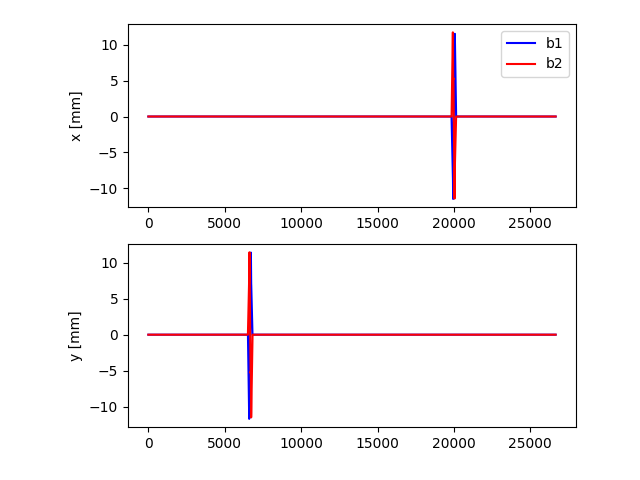

In [8]:
plt.figure()
ax1 = plt.subplot(2,1,1)
plt.plot(tw1.s, 1e3*tw1.x, color='b', label='b1')
plt.plot(tw2.s, 1e3*tw2.x, color='r', label='b2')
plt.ylabel('x [mm]')
plt.legend()
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(tw1.s, 1e3*tw1.y, color='b')
plt.plot(tw2.s, 1e3*tw2.y, color='r')
plt.ylabel('y [mm]')
plt.subplots_adjust(left=0.2, top=.95)

#### Configure beam beam

In [9]:
collider.configure_beambeam_interactions(
                crab_strong_beam=False,
                num_particles=2.3e11,
                nemitt_x=2e-6, nemitt_y=2e-6)

#### Compute and plot footprint

Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Done computing footprint.


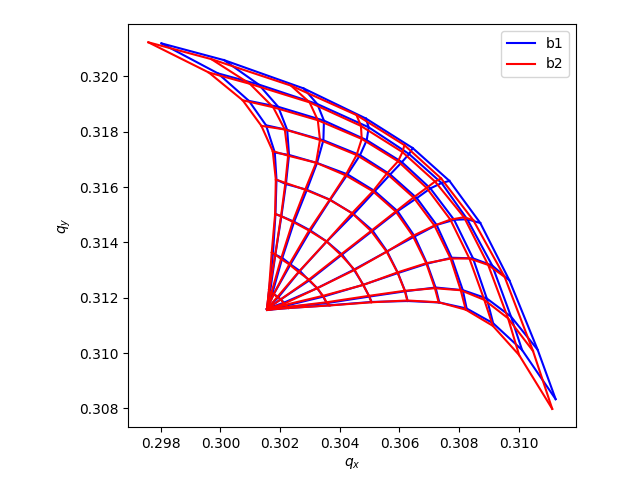

In [10]:
plt.figure()
fp_b1 = collider.lhcb1.get_footprint(
    nemitt_x=2.5e-6, nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name='beambeam_scale', v0=0.0, dv=0.1)])
fp_b1.plot(color='b', label='b1')

fp_b2 = collider.lhcb2.get_footprint(
    nemitt_x=2.5e-6, nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[
        xt.LinearRescale(knob_name='beambeam_scale', v0=0.0, dv=0.1)])
fp_b2.plot(color='r', label='b2')
plt.legend()

plt.subplots_adjust(left=0.2, top=.95)

plt.savefig('fp.png', dpi=220)

#### Dynamic aperture

In [11]:
# Some octupoles (to see losses on a small number of turns)
for arc in ['12', '23', '34', '45', '56', '67', '78', '81']:
    collider.vars[f'kod.a{arc}b1'] = 9.0
    collider.vars[f'kof.a{arc}b2'] = 9.0
    collider.vars[f'kod.a{arc}b2'] = 9.0
    collider.vars[f'kof.a{arc}b2'] = 9.0

#### Genearate polar particle distribution

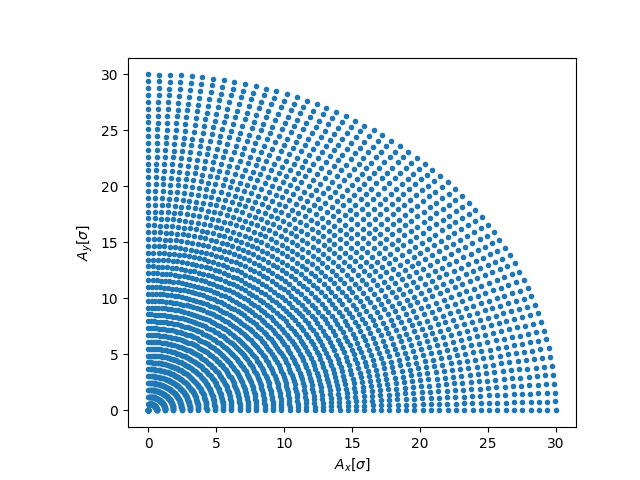

In [12]:
n_r = 50
n_theta = 60
x_normalized, y_normalized, r_xy, theta_xy = xp.generate_2D_polar_grid(
    r_range=(0, 30.), # beam sigmas
    theta_range=(0, np.pi/2),
    nr=n_r, ntheta=n_theta)

plt.figure()
plt.plot(x_normalized, y_normalized, '.')
plt.xlabel(r'$A_x [\sigma]$')
plt.ylabel(r'$A_y [\sigma]$')
plt.subplots_adjust(left=0.2)

#### Match particles to the machine optics and orbit

In [13]:
particles_b1 = collider.lhcb1.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=3e-6, nemitt_y=3e-6, # normalized emittances
    delta=0)

particles_b2 = collider.lhcb2.build_particles(
    x_norm=x_normalized, px_norm=0,
    y_norm=y_normalized, py_norm=0,
    nemitt_x=3e-6, nemitt_y=3e-6, # normalized emittances
    delta=0)

#### Activate multi-core CPU parallelization

In [14]:
collider.discard_trackers()
collider.lhcb1.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
collider.lhcb2.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Track B1 and B2

In [15]:
collider.lhcb1.track(particles_b1, num_turns=300, with_progress=5)
collider.lhcb2.track(particles_b2, num_turns=300, with_progress=5)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

#### Display result

In [16]:
# Sort particles to get the initial order
# (during tracking lost particles are moved to the end)
particles_b1.sort(interleave_lost_particles=True)
particles_b2.sort(interleave_lost_particles=True)

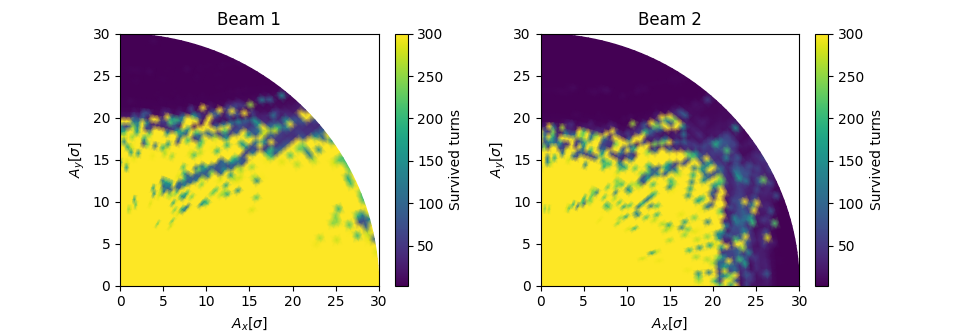

In [17]:
plt.figure(figsize=(6.4*1.5, 4.8*0.7))
plt.subplot(1,2,1)
plt.pcolormesh(
    x_normalized.reshape(n_r, n_theta), y_normalized.reshape(n_r, n_theta),
    particles_b1.at_turn.reshape(n_r, n_theta), shading='gouraud')
plt.xlabel(r'$A_x [\sigma]$')
plt.ylabel(r'$A_y [\sigma]$')
ax = plt.colorbar()
ax.set_label('Survived turns')
plt.title('Beam 1')

plt.subplot(1,2,2)
plt.pcolormesh(
    x_normalized.reshape(n_r, n_theta), y_normalized.reshape(n_r, n_theta),
    particles_b2.at_turn.reshape(n_r, n_theta), shading='gouraud')
plt.xlabel(r'$A_x [\sigma]$')
plt.ylabel(r'$A_y [\sigma]$')
ax = plt.colorbar()
ax.set_label('Survived turns')
plt.title('Beam 2')

plt.subplots_adjust(wspace=0.3, top=.9, bottom=.15)